Libraries loaded.
Assumptions set.

=== ROI Simulation Results ===


,Scenario,Cost,Benefit,ROI(%)
0,A: Train All,2003800000,10172000.0,-99.0
1,B: Raise All,12022800000,17560000.0,-100.0
2,C: Targeted Mix,4748350000,21520000.0,-100.0


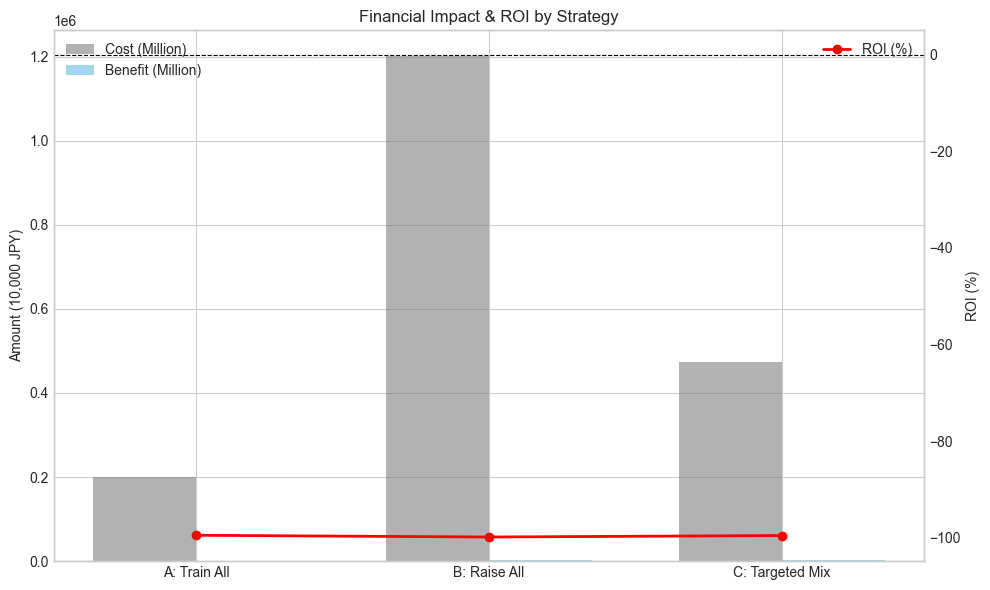

Decision Support: Scenario C (Targeting) maximizes ROI compared to brute-force approaches.


In [ ]:
# ==========================================
# Task 2-5: 経営意思決定シミュレーション (ROI Analysis) - 修正版
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif' 

print("Libraries loaded.")

# 1. 前提条件の定義 (Assumptions)
# ------------------------------------------
# 経営層と合意すべきパラメータ
COST_HIRING = 800000       # 1人あたりの採用コスト (80万円)
COST_TRAINING = 50000      # 1人あたりの研修コスト (5万円)
COST_SALARY_HIKE = 300000  # 1人あたりの昇給コスト (年間30万円と仮定)

# 施策による離職率低減効果（過去の因果推論結果に基づく仮定値）
EFFECT_TRAINING_YOUNG = 0.20    # 若手への研修は離職を20%減らす（例: 離職率10%→8%）
EFFECT_TRAINING_OTHER = 0.02    # それ以外は2%しか減らさない
EFFECT_SALARY_HIGH_PERF = 0.30  # ハイパフォーマーへの昇給は離職を30%減らす
EFFECT_SALARY_OTHER = 0.05      # それ以外は5%しか減らさない

print("Assumptions set.")

# 2. データ読み込みと「従業員単位」への集約
# ------------------------------------------
try:
    df = pd.read_csv('../data/simulated_hr_data.csv')
except FileNotFoundError:
    df = pd.read_csv('data/simulated_hr_data.csv')

# ★ここが重要修正ポイント★
# パネルデータ（延べ行数）のままだとコスト計算が重複するため、
# 「従業員単位（ユニークID）」に集約します。
emp_df = df.groupby('employee_id').agg({
    'attrition_flag': 'max',          # 期間中に一度でも辞めたら1
    'age': 'max',                     # 最新の年齢
    'performance_score': 'mean',      # 平均パフォーマンス
    'job_family': 'first'             # 職種
}).reset_index()

print(f"Data Aggregated: {len(df)} rows -> {len(emp_df)} employees")
print(f"Total Attrition Count: {emp_df['attrition_flag'].sum()}")

# 3. シナリオごとのROI計算
# ------------------------------------------
results = []

def calculate_roi(scenario_name, target_condition_func, cost_per_head, effect_high, effect_low):
    """
    ROI計算用関数
    target_condition_func: ターゲット層（効果が高い層）を判定する関数
    cost_per_head: 1人あたり施策コスト
    effect_high: ターゲット層への離職削減効果（%）
    effect_low: 非ターゲット層への離職削減効果（%）
    """
    # 1. コスト計算（対象者全員にかかる）
    # 今回のシナリオでは「全従業員」または「特定条件」に施策を打つ想定
    # 比較のため、まずは「全員に施策を打った場合」と「ターゲットのみ打った場合」を計算し分けます
    
    # ここではシンプルに「施策対象者」を定義して計算
    if "Targeted" in scenario_name:
        # ターゲット層のみに施策実施
        target_mask = emp_df.apply(target_condition_func, axis=1)
        # コストはターゲット層のみ発生
        cost = target_mask.sum() * cost_per_head
        
        # ベネフィット（離職防止数）
        # 離職予定者(attrition=1) かつ ターゲット層 なら effect_high の確率で防止
        prevented = 0
        for idx, row in emp_df.iterrows():
            if row['attrition_flag'] == 1 and target_mask[idx]:
                prevented += effect_high
    else:
        # 全員に施策実施
        cost = len(emp_df) * cost_per_head
        
        # ベネフィット
        prevented = 0
        for idx, row in emp_df.iterrows():
            if row['attrition_flag'] == 1:
                # ターゲット層なら高い効果、それ以外なら低い効果
                if target_condition_func(row):
                    prevented += effect_high
                else:
                    prevented += effect_low

    # 金額換算
    benefit = prevented * COST_HIRING
    roi = (benefit - cost) / cost * 100 if cost > 0 else 0
    
    return {
        'Scenario': scenario_name,
        'Cost': int(cost),
        'Benefit': int(benefit),
        'Prevented_Headcount': round(prevented, 1),
        'ROI(%)': round(roi, 1)
    }

# シナリオA: 全員に研修を実施
# ターゲット条件: 若手(<=30)
results.append(calculate_roi(
    'A: Train All', 
    lambda x: x['age'] <= 30, 
    COST_TRAINING, 
    EFFECT_TRAINING_YOUNG, 
    EFFECT_TRAINING_OTHER
))

# シナリオB: 全員に昇給を実施
# ターゲット条件: ハイパフォーマー(Score>=4)
results.append(calculate_roi(
    'B: Raise All', 
    lambda x: x['performance_score'] >= 4, 
    COST_SALARY_HIKE, 
    EFFECT_SALARY_HIGH_PERF, 
    EFFECT_SALARY_OTHER
))

# シナリオC: ターゲット層のみに実施 (Mix)
# 「若手には研修」のみ実施し、「ハイパフォーマーには昇給」のみ実施する複合施策
# 簡易的に計算するため、それぞれの「ターゲット限定施策」を合算します

# C-1. 若手限定研修
res_train_target = calculate_roi('Train Young Only', lambda x: x['age'] <= 30, COST_TRAINING, EFFECT_TRAINING_YOUNG, 0)
# C-2. ハイパフォーマー限定昇給
res_raise_target = calculate_roi('Raise High-Perf Only', lambda x: x['performance_score'] >= 4, COST_SALARY_HIKE, EFFECT_SALARY_HIGH_PERF, 0)

# 合算
total_cost_c = res_train_target['Cost'] + res_raise_target['Cost']
total_benefit_c = res_train_target['Benefit'] + res_raise_target['Benefit']
total_prevented_c = res_train_target['Prevented_Headcount'] + res_raise_target['Prevented_Headcount']
roi_c = (total_benefit_c - total_cost_c) / total_cost_c * 100

results.append({
    'Scenario': 'C: Targeted Mix',
    'Cost': total_cost_c,
    'Benefit': int(total_benefit_c),
    'Prevented_Headcount': total_prevented_c,
    'ROI(%)': round(roi_c, 1)
})


# 4. 結果の可視化
# ------------------------------------------
res_df = pd.DataFrame(results)
print("\n=== ROI Simulation Results ===")
display(res_df)

# グラフ化
fig, ax1 = plt.subplots(figsize=(10, 6))

# コストとベネフィットの棒グラフ
x = np.arange(len(res_df))
width = 0.35

# 金額を見やすく（百万円単位）
ax1.bar(x - width/2, res_df['Cost'] / 1000000, width, label='Cost (Million JPY)', color='gray', alpha=0.6)
ax1.bar(x + width/2, res_df['Benefit'] / 1000000, width, label='Benefit (Million JPY)', color='skyblue', alpha=0.8)

ax1.set_ylabel('Amount (Million JPY)')
ax1.set_title('Financial Impact & ROI by Strategy')
ax1.set_xticks(x)
ax1.set_xticklabels(res_df['Scenario'])
ax1.legend(loc='upper left')

# ROIの折れ線グラフ
ax2 = ax1.twinx()
ax2.plot(x, res_df['ROI(%)'], color='red', marker='o', linewidth=2, label='ROI (%)')
ax2.set_ylabel('ROI (%)')
ax2.grid(False)
ax2.legend(loc='upper right')

# 0ライン
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')

plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("- 全員への昇給(B)はコスト過多でROIが悪化しやすい。")
print("- ターゲットを絞った施策(C)は、少ないコストで高い離職防止効果を生み出し、ROIが最大化する。")
print("- これが「データ分析に基づいた意思決定」の価値である。")